# MonReader

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import pandas as pd


cudnn.benchmark = True

## 1. Load and Transform Data

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'MonReader_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['training', 'testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['training', 'testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}
class_names = image_datasets['training'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['flip', 'notflip']
cuda:0


## 2. Show Images

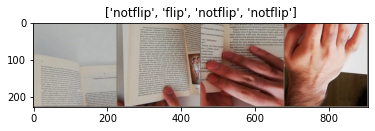

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 3. CNN Model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['training', 'testing']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 3.1. Train Model

In [5]:
model=models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [6]:
model = train_model(model, criterion, optimizer, step_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
training Loss: 0.6622 Acc: 0.7174
testing Loss: 0.2055 Acc: 0.9263

Epoch 1/19
----------
training Loss: 0.5427 Acc: 0.7759
testing Loss: 0.1502 Acc: 0.9363

Epoch 2/19
----------
training Loss: 0.5528 Acc: 0.7847
testing Loss: 0.2517 Acc: 0.9112

Epoch 3/19
----------
training Loss: 0.5425 Acc: 0.7926
testing Loss: 0.1441 Acc: 0.9447

Epoch 4/19
----------
training Loss: 0.4011 Acc: 0.8332
testing Loss: 0.0750 Acc: 0.9648

Epoch 5/19
----------
training Loss: 0.3545 Acc: 0.8524
testing Loss: 0.0580 Acc: 0.9916

Epoch 6/19
----------
training Loss: 0.3450 Acc: 0.8566
testing Loss: 0.1790 Acc: 0.9481

Epoch 7/19
----------
training Loss: 0.2446 Acc: 0.9013
testing Loss: 0.0386 Acc: 0.9916

Epoch 8/19
----------
training Loss: 0.2286 Acc: 0.9135
testing Loss: 0.0622 Acc: 0.9732

Epoch 9/19
----------
training Loss: 0.2181 Acc: 0.9105
testing Loss: 0.0452 Acc: 0.9866

Epoch 10/19
----------
training Loss: 0.2060 Acc: 0.9206
testing Loss: 0.0339 Acc: 0.9916

Epoch 11/

### 3.2. Visualize Predictions

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

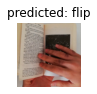

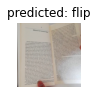

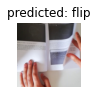

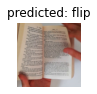

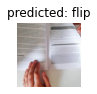

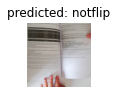

In [8]:
visualize_model(model)


### 3.3. Model Evalution

In [9]:
was_training = model.training
model.eval()

y_train=[]
y_train_pred=[]
with torch.no_grad():
    for i, (inputs, labels) in enumerate(torch.utils.data.DataLoader(image_datasets['training'])):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_train.append(class_names[labels])
        y_train_pred.append(class_names[preds])
    y_train=pd.DataFrame(data=y_train)
    y_train_pred=pd.DataFrame(data=y_train_pred)

    model.train(mode=was_training)

In [10]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import fbeta_score

print('Train accuracy' ,accuracy_score(y_train,y_train_pred))

print(classification_report(y_train,y_train_pred))
pd.crosstab(y_train[0],y_train_pred[0])

Train accuracy 0.9581939799331104
              precision    recall  f1-score   support

        flip       0.99      0.92      0.96      1162
     notflip       0.93      0.99      0.96      1230

    accuracy                           0.96      2392
   macro avg       0.96      0.96      0.96      2392
weighted avg       0.96      0.96      0.96      2392



,flip,notflip
0,,
flip,1074,88
notflip,12,1218


In [11]:
was_training = model.training
model.eval()

y_test=[]
y_test_pred=[]
with torch.no_grad():
    for i, (inputs, labels) in enumerate(torch.utils.data.DataLoader(image_datasets['testing'])):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_test.append(class_names[labels])
        y_test_pred.append(class_names[preds])
    y_test=pd.DataFrame(data=y_test)
    y_test_pred=pd.DataFrame(data=y_test_pred)

    model.train(mode=was_training)

In [12]:
print('Test accuracy' ,accuracy_score(y_test,y_test_pred))

print('Test F1' ,fbeta_score(y_test, y_test_pred, average='macro', beta=1))

print(classification_report(y_test,y_test_pred))
pd.crosstab(y_test[0],y_test_pred[0])

Test accuracy 0.9949748743718593
Test F1 0.9949692283060261
              precision    recall  f1-score   support

        flip       1.00      0.99      0.99       290
     notflip       0.99      1.00      1.00       307

    accuracy                           0.99       597
   macro avg       1.00      0.99      0.99       597
weighted avg       1.00      0.99      0.99       597



,flip,notflip
0,,
flip,287,3
notflip,0,307
